In [381]:
#Importing Libraries
import pandas as pd
import numpy as np
import logging
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer


%matplotlib inline

In [382]:
#Importing Libraries
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score

In [383]:
#Reading dataset
df= pd.read_csv('train (1).csv')

## Basic EDA

In [384]:
df.head(5)

,unique ID,query_text,category
0,0,HTTPS://VIMEO.COM/107297364﻿,junk
1,1,Art and Culture,general
2,2,Differentiate between chemical and biological ...,academic_servable
3,3,nth Term of an AP,academic_servable
4,4,bunmei kaika: aoiza ibunroku saien,junk


In [385]:
df.isnull().sum()

unique ID     0
query_text    0
category      0
dtype: int64

In [386]:
total_word_count = 0
for text in df['query_text']:
    total_word_count += len(text.split(' '))
total_word_count

83817

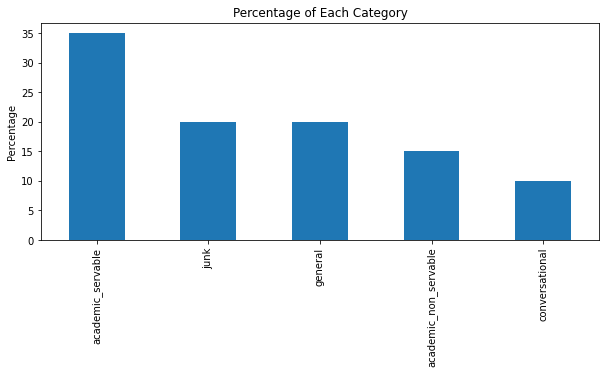

In [387]:
import matplotlib.pyplot as plt

# Calculate the percentage of each category
category_counts = df['category'].value_counts()
total_samples = len(df)
category_percentages = (category_counts / total_samples) * 100

# Plot the percentages
plt.figure(figsize=(10, 4))
category_percentages.plot(kind='bar')
plt.ylabel('Percentage')
plt.title('Percentage of Each Category')
plt.show()


## Feature Engineering

In [388]:
# Apply text preprocessing steps
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = re.sub(r'\W+', ' ', text)     # Remove non-alphanumeric characters
    text = text.lower()                  # Convert text to lowercase
    text = re.sub(r'[^\w\s,]', '', text) # Remove emojis
    return text


In [389]:
# Apply text preprocessing to 'query_text' column
df['query_text'] = df['query_text'].apply(preprocess_text)

In [390]:
# Tokenization, stopword removal, and stemming/lemmatization
def tokenize_and_process(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    stemmer = SnowballStemmer('english')
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]
    return ' '.join(lemmatized_tokens)  # Convert tokens back to text

In [391]:
# Apply tokenization and processing to 'query_text' column
df['query_text'] = df['query_text'].apply(tokenize_and_process)

In [392]:
# Split into features (X) and labels (y)
X = df['query_text']
y = df['category']

In [393]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the text data to obtain TF-IDF representation
X_tfidf = vectorizer.fit_transform(X)

In [394]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_tfidf, y, test_size=0.30, random_state=42)

## Doing OverSampling on Data 

In [395]:
from imblearn.over_sampling import RandomOverSampler

# Initialize RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Fit and apply the oversampling to the training data
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)


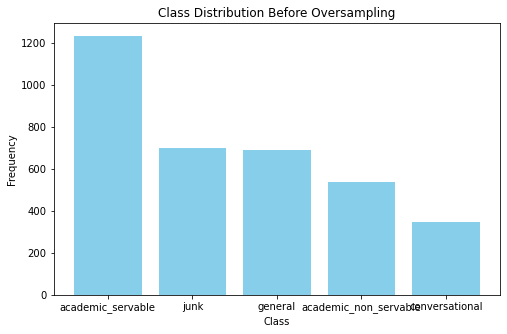

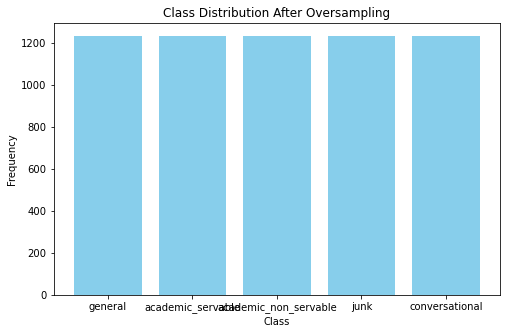

In [396]:
import matplotlib.pyplot as plt

# Function to plot class distribution
def plot_class_distribution(y, title):
    class_counts = y.value_counts()
    class_labels = class_counts.index
    plt.figure(figsize=(8, 5))
    plt.bar(class_labels, class_counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Plot class distribution before oversampling
plot_class_distribution(y_train, title='Class Distribution Before Oversampling')

# Plot class distribution after oversampling
plot_class_distribution(y_train_balanced, title='Class Distribution After Oversampling')


## Applying Naive Bayes Classifier

In [397]:
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_balanced, y_train_balanced)
y_pred = nb_classifier.predict(X_test)

In [398]:
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.5753333333333334
Classification Report:
                       precision    recall  f1-score   support

academic_non_servable       0.49      0.83      0.61       215
    academic_servable       0.75      0.43      0.55       519
       conversational       0.34      0.73      0.46       153
              general       0.67      0.71      0.69       313
                 junk       0.74      0.42      0.54       300

             accuracy                           0.58      1500
            macro avg       0.60      0.62      0.57      1500
         weighted avg       0.65      0.58      0.58      1500



In [399]:
# Encode the target variable for the test set
y_test_encoded = label_encoder.transform(y_test)

## Applying multiple Ensemble methods

In [400]:
# Initialize the models with the best parameters
best_logistic_regression = LogisticRegression(C=10, solver='liblinear')
best_svc = SVC(C=1, gamma='scale', kernel='linear')
best_kneighbors = KNeighborsClassifier(algorithm='auto', n_neighbors=3, weights='distance')
best_decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_leaf=1, min_samples_split=2)
best_random_forest = RandomForestClassifier(bootstrap=False, max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=10, n_estimators=300)

# Fit the models to your training data
best_logistic_regression.fit(X_train_balanced, y_train_balanced)
best_svc.fit(X_train_balanced, y_train_balanced)
best_kneighbors.fit(X_train_balanced, y_train_balanced)
best_decision_tree.fit(X_train_balanced, y_train_balanced)
best_random_forest.fit(X_train_balanced, y_train_balanced)


RandomForestClassifier(bootstrap=False, max_features='log2',
                       min_samples_split=10, n_estimators=300)

In [401]:
from sklearn.metrics import accuracy_score, classification_report

# Function to print accuracy and classification report
def print_metrics(model, X_train_balanced, y_train_balanced, X_test, y_test_encoded):
    # Train predictions
    train_predictions = model.predict(X_train_balanced)
    train_accuracy = accuracy_score(y_train_balanced, train_predictions)
    train_report = classification_report(y_train_balanced, train_predictions)

    # Test predictions
    test_predictions = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_report = classification_report(y_test, test_predictions)

    print(f"Training Accuracy: {train_accuracy}")
    print("Training Classification Report:")
    print(train_report)

    print("\n" + "="*50 + "\n")

    print(f"Test Accuracy: {test_accuracy}")
    print("Test Classification Report:")
    print(test_report)

# Print metrics for Logistic Regression
print("Logistic Regression Metrics:")
print_metrics(best_logistic_regression, X_train_balanced, y_train_balanced, X_test, y_test_encoded)

# Print metrics for SVC
print("\nSVC Metrics:")
print_metrics(best_svc, X_train_balanced, y_train_balanced, X_test, y_test_encoded)

# Print metrics for K-Neighbors Classifier
print("\nK-Neighbors Classifier Metrics:")
print_metrics(best_kneighbors, X_train_balanced, y_train_balanced, X_test, y_test_encoded)

# Print metrics for Decision Tree Classifier
print("\nDecision Tree Classifier Metrics:")
print_metrics(best_decision_tree, X_train_balanced, y_train_balanced, X_test, y_test_encoded)

# Print metrics for Random Forest Classifier
print("\nRandom Forest Classifier Metrics:")
print_metrics(best_random_forest, X_train_balanced, y_train_balanced, X_test, y_test_encoded)


Logistic Regression Metrics:
Training Accuracy: 0.9770917952883834
Training Classification Report:
                       precision    recall  f1-score   support

academic_non_servable       1.00      0.99      0.99      1231
    academic_servable       0.92      0.99      0.96      1231
       conversational       0.98      0.98      0.98      1231
              general       0.99      0.98      0.99      1231
                 junk       1.00      0.95      0.97      1231

             accuracy                           0.98      6155
            macro avg       0.98      0.98      0.98      6155
         weighted avg       0.98      0.98      0.98      6155



Test Accuracy: 0.6746666666666666
Test Classification Report:
                       precision    recall  f1-score   support

academic_non_servable       0.83      0.70      0.76       215
    academic_servable       0.62      0.80      0.70       519
       conversational       0.62      0.52      0.57       153
              

## Creating model pipeline

In [380]:
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = re.sub(r'\W+', ' ', text)     # Remove non-alphanumeric characters
    text = text.lower()                  # Convert text to lowercase
    text = re.sub(r'[^\w\s,]', '', text) # Remove emojis
    return text

# Function for tokenization, stopword removal, and lemmatization
def tokenize_and_process(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    stemmer = SnowballStemmer('english')
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]
    return ' '.join(lemmatized_tokens)

# Read the data
df = pd.read_csv('train (1).csv')

# Preprocess the text
df['query_text'] = df['query_text'].apply(preprocess_text)
df['query_text'] = df['query_text'].apply(tokenize_and_process)

# Split into features (X) and labels (y)
X = df['query_text']
y = df['category']

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the text data to obtain TF-IDF representation
X_tfidf = vectorizer.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.30, random_state=42)

# Apply RandomOverSampler to address class imbalance
oversampler = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)

# Initialize and train the Random Forest classifier
random_forest_classifier = RandomForestClassifier(bootstrap=False, max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=10, n_estimators=300)
random_forest_classifier.fit(X_train_balanced, y_train_balanced)

# Function to make predictions and print metrics
def make_predictions_and_print_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(report)

# Make predictions and print metrics for the Random Forest classifier
make_predictions_and_print_metrics(random_forest_classifier, X_test, y_test)


Accuracy: 0.7046666666666667
Classification Report:
                       precision    recall  f1-score   support

academic_non_servable       0.91      0.77      0.84       215
    academic_servable       0.74      0.71      0.73       519
       conversational       0.67      0.58      0.62       153
              general       0.83      0.64      0.72       313
                 junk       0.52      0.77      0.62       300

             accuracy                           0.70      1500
            macro avg       0.74      0.70      0.71      1500
         weighted avg       0.73      0.70      0.71      1500



## Testing model on test.csv

In [350]:
import joblib

# Save the trained Random Forest classifier
joblib.dump(random_forest_classifier, 'random_forest_classifier.pkl')

['random_forest_classifier.pkl']

In [351]:
import pandas as pd
import joblib

# Load the trained Random Forest classifier
random_forest_classifier = joblib.load('random_forest_classifier.pkl')

# Read the test data
test_df = pd.read_csv('test (2).csv')

# Preprocess the text in the test data
test_df['query_text'] = test_df['query_text'].apply(preprocess_text)
test_df['query_text'] = test_df['query_text'].apply(tokenize_and_process)

# Transform the preprocessed text using the TfidfVectorizer
X_test_tfidf = vectorizer.transform(test_df['query_text'])

# Make predictions on the test data
predictions = random_forest_classifier.predict(X_test_tfidf)

# Create a DataFrame to store the query and prediction results
submission_df = pd.DataFrame({'query_text': test_df['query_text'], 'prediction': predictions})

# Save the DataFrame to sample_submission.csvfrom sklearn.externals import joblib
submission_df.to_csv('sample_submission.csv', index=False)
